In [44]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.metrics import edit_distance

from transformers import AutoTokenizer

random.seed(6)
np.random.seed(6)


# One-Shot prompting with no HTML tags

Here we repeat one of the first experiments to see if the HTML tags actually give any boost to accuracy.


**Parameters:**
- model: llama3.2:3b
- system prompt: MCQ_system_prompt_v2_oneshot.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [45]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [46]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/nohtml_tags_oneshot_responses_llama3.2_20250227_14:09:28.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,This space is reserved for your reasoning abou...
Interaction_T1_14,To determine which object was tidied up by the...
Interaction_T1_31,This space is reserved for your reasoning abou...
Interaction_T1_32,This space is reserved for your reasoning abou...
Interaction_T1_40,This space is reserved for your reasoning abou...
...,...
Feasibility_T6_1453,To determine what the person is able to do aft...
Feasibility_T6_1454,"Based on the Spatio-Temporal Scene Graphs, I c..."
Feasibility_T6_1455,This space is reserved for your reasoning abou...


In [47]:
predictions_df.iloc[0:20]['answer'].apply(print)


This space is reserved for your reasoning about the question.

To determine which object was tidied up by the person, we need to analyze the sequence of events unfolding in the frames. 

The first two Scene-Graphs show the person standing next to the clothes and then standing in front of the clothes. This suggests that the person is picking up or arranging the clothes.

However, the third Scene-Graph introduces a new object, the blanket, which is also being arranged by the person. The subsequent Scene-Graphs continue to show the person interacting with both the clothes and the blanket.

The key insight here is that the person's interaction with the blanket appears to be tidying up or arranging it in some way, whereas their interaction with the clothes seems more focused on picking them up or putting them away.

Given this analysis, I would choose:

A: 1. The blanket.
To determine which object was tidied up by the person, we need to analyze the Scene-Graphs and identify the relationship

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

Let's start by viewing how many answers follow the template:

In [48]:
# Check if the the template is somewhere in the answer
#
# An example of the template expressed by the regex is: A: 1. The answer.
# where the number followed by a dot is optional
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


/tmp/ipykernel_312736/2545864474.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


Answer following the template: 6436
90.67% of the total

Only 662 samples do not contain the answer in the response with the specified format


In [49]:
predictions_df.loc[~contains_answer].iloc[:100]['answer'].apply(lambda x: print(x, '\n\n'))


This space is reserved for your reasoning about the question.

To determine which object was thrown by the person, we need to look for a Scene-Graph that indicates the person is holding an object and then releases it. 

From the given STSG, I notice that there are multiple instances where the person is holding clothes and then moves them to different positions (e.g., 'person - holding - clothes', 'person - on_the_side_of - clothes', etc.). However, none of these instances explicitly show the person throwing an object.

But, I do see a Scene-Graph that shows the person in front of clothes and then moving it to the side: ['person - in_front_of - clothes']. This could be interpreted as the person picking up or putting down clothes, but not necessarily throwing an object.

However, another possible interpretation is that the person is holding clothes and then moves them to a position where they are no longer being held by the person. In this case, I notice that there is a Scene-Graph that 

id
Interaction_T1_43      None
Interaction_T1_100     None
Interaction_T1_263     None
Interaction_T1_287     None
Interaction_T1_357     None
                       ... 
Interaction_T1_8895    None
Interaction_T1_9122    None
Interaction_T1_9140    None
Interaction_T1_9217    None
Interaction_T1_9268    None
Name: answer, Length: 100, dtype: object

## Distribution of generated response lengths measured in tokens

In [50]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [51]:
resp_token_len = pd.Series(index=predictions_df.index)

for index, row in predictions_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['answer']))

resp_token_len.sort_values().value_counts(sort=False)


/tmp/ipykernel_312736/4005420109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resp_token_len = pd.Series(index=predictions_df.index)


5.0        2
6.0       23
7.0        2
8.0        2
9.0       12
          ..
8148.0     1
8166.0     1
8191.0     2
8192.0     5
8193.0    85
Length: 500, dtype: int64

The responses with a token length of 12 are those that caused an error during generation (mainly due to time-out 4mins):

count    7098.000000
mean      327.297267
std      1033.683775
min         5.000000
25%       140.000000
50%       178.000000
75%       224.000000
max      8193.000000
dtype: float64

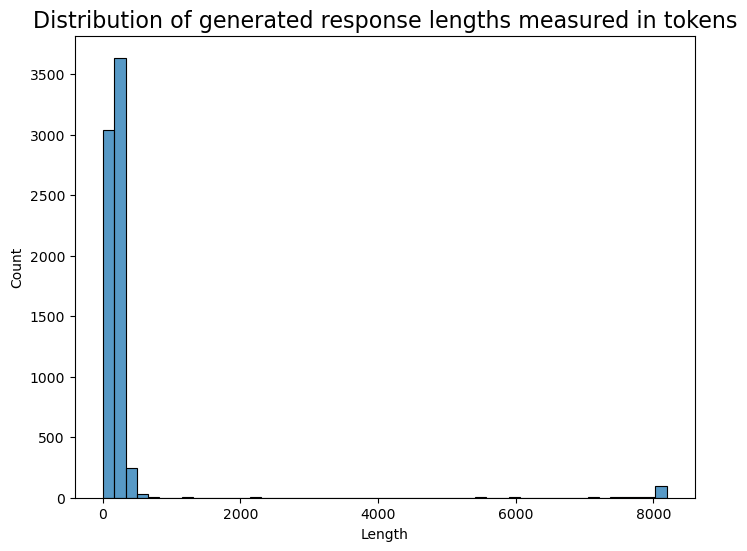

In [52]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [53]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The blanket.
Interaction_T1_14,The clothes.
Interaction_T1_31,The bag.
Interaction_T1_32,The shoe.
Interaction_T1_40,The clothes.
...,...
Feasibility_T6_1449,Put down the laptop.
Feasibility_T6_1453,Put down the phone/camera.
Feasibility_T6_1455,Take the shoe.


In [54]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 456 unique answers


In [55]:
ans_df['text'].value_counts()


Put down.                    442
The towel.                   316
Took.                        252
Tidied up.                   230
The clothes.                 221
                            ... 
The food and/or the dish.      1
Hold the mirror.               1
Sit on the table.              1
Lie on the bed.                1
Wash the window.               1
Name: text, Length: 228, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

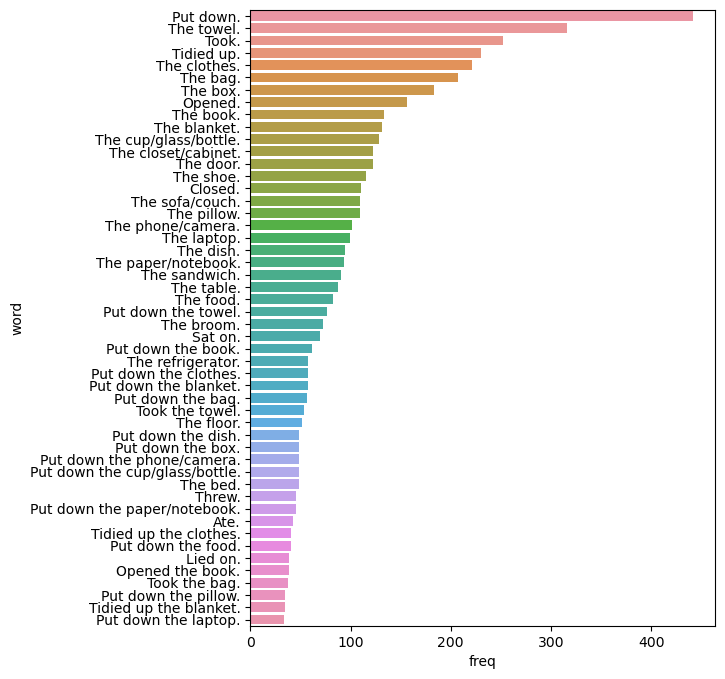

In [56]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [57]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


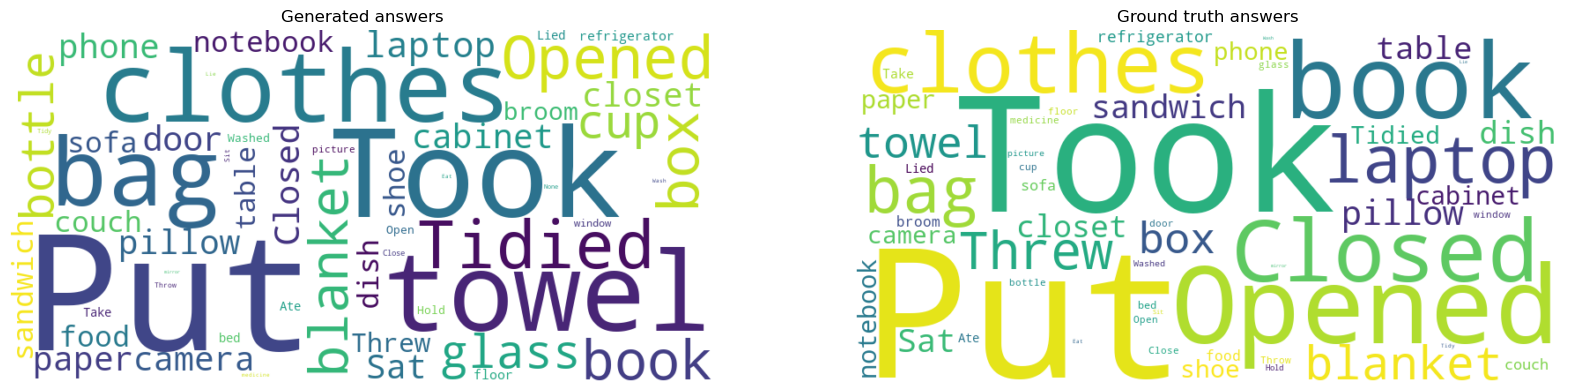

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

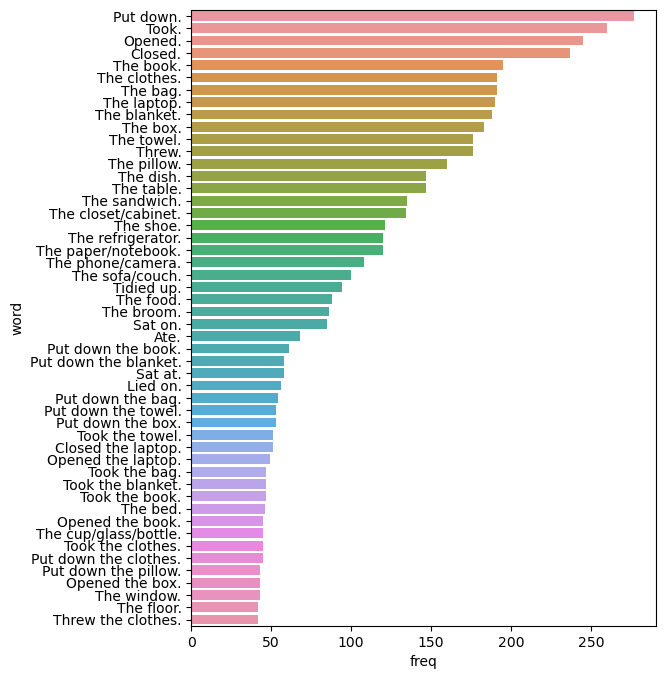

In [59]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [60]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6436, 4)

In [61]:
eval_df['edit_distance'] = eval_df.apply(func=lambda row: edit_distance(row['text'], row['pred_text']), axis=1)

eval_df['edit_distance'].sort_values(ascending=True).value_counts(sort=False)


0     3014
2       31
3       56
4      386
5      390
6      286
7      631
8      419
9      104
10     157
11     188
12     182
13     176
14      97
15      81
16      28
17      54
18      40
19      48
20      32
21      17
22      14
23       2
24       1
31       1
42       1
Name: edit_distance, dtype: int64

In [62]:
eval_df[(eval_df['edit_distance'] > 0) & (eval_df['edit_distance'] < 3)]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_526,"{'0': 'The book.', '1': 'The bag.', '2': 'The ...",0,The book.,The door.,2
Interaction_T1_714,"{'0': 'The door.', '1': 'The book.', '2': 'The...",1,The book.,The door.,2
Interaction_T1_2119,"{'0': 'The clothes.', '1': 'The food.', '2': '...",3,The book.,The box.,2
Interaction_T1_3854,"{'0': 'The box.', '1': 'The laptop.', '2': 'Th...",3,The bag.,The box.,2
Interaction_T1_4398,"{'0': 'The refrigerator.', '1': 'The closet/ca...",2,The book.,The door.,2
Interaction_T1_4629,"{'0': 'The box.', '1': 'The door.', '2': 'The ...",3,The book.,The door.,2
Interaction_T1_6212,"{'0': 'The food.', '1': 'The bag.', '2': 'The ...",2,The book.,The food.,2
Interaction_T1_6586,"{'0': 'The box.', '1': 'The door.', '2': 'The ...",3,The book.,The door.,2
Interaction_T1_6975,"{'0': 'The closet/cabinet.', '1': 'The laptop....",2,The book.,The door.,2


In [63]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [64]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 46.83%


In [65]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.,0
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.,0
Interaction_T1_78,"{'0': 'The laptop.', '1': 'The refrigerator.',...",0,The laptop.,The laptop.,0
Interaction_T1_81,"{'0': 'The bed.', '1': 'The sofa/couch.', '2':...",1,The sofa/couch.,The sofa/couch.,0
Interaction_T1_111,"{'0': 'The refrigerator.', '1': 'The door.', '...",3,The closet/cabinet.,The closet/cabinet.,0
...,...,...,...,...,...
Feasibility_T6_1413,"{'0': 'Wash the table.', '1': 'Open the box.',...",3,Open the book.,Open the book.,0
Feasibility_T6_1428,"{'0': 'Close the refrigerator.', '1': 'Throw t...",3,Take the cup/glass/bottle.,Take the cup/glass/bottle.,0
Feasibility_T6_1430,"{'0': 'Tidy up the closet/cabinet.', '1': 'Tak...",3,Wash the dish.,Wash the dish.,0


check if the equality with NA result in a false or is skipped

In [66]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 42.46%


In [67]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [68]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2171        46.34%  
Sequence            3229        47.20%  
Prediction           585        42.74%  
Feasibility          451        51.88%  


In [69]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        90.53%  
Sequence            3586        90.04%  
Prediction           624        93.75%  
Feasibility          490        92.04%  
Overall             7098        90.67%  
